### A
Cluster the text features. Can you find meaningful clusters?

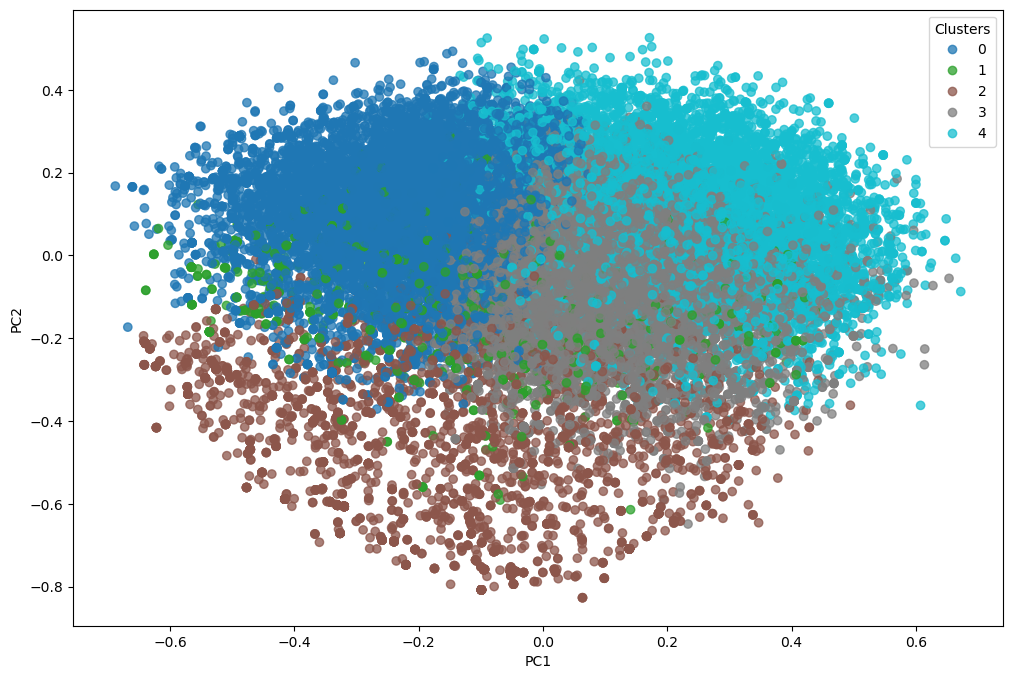

In [11]:
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt

# load metadata and annotations
dataset_path = 'MLPC2025_dataset'
metadata_df = pd.read_csv(os.path.join(dataset_path, 'metadata.csv'))
annotations_df = pd.read_csv(os.path.join(dataset_path, 'annotations.csv'))
annotations_embeddings = np.load(os.path.join(dataset_path, 'annotations_text_embeddings.npz'))['embeddings']

# cluster
number_of_clusters = 5
kmeans = sklearn.cluster.KMeans(n_clusters=number_of_clusters, random_state=0)
annotations_df['cluster'] = kmeans.fit_predict(annotations_embeddings)

# downsize with pca
pca = sklearn.decomposition.PCA(n_components=2)
reduced_embeddings = pca.fit_transform(annotations_embeddings)

# plot results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=annotations_df['cluster'], cmap='tab10', alpha=0.75)
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [12]:
for cluster_id in sorted(annotations_df['cluster'].unique()):
    samples = annotations_df[annotations_df['cluster'] == cluster_id]['text'].sample(5)
    print(f"\nCluster {cluster_id}:")
    for sample in samples:
        print(f"  - {sample}")


Cluster 0:
  - People talking calmly and distantly outdoors.
  - A man speaking from a distant TV in a bar
  - A man talking.
  - Strong wind blowing into the recording device
  - A quiet rustling sound occuring in the background.

Cluster 1:
  - a dog barking
  - The quiet, distant, repeated barking of an dog
  - Dogs barking quietly in the background.
  - a dog barks loud
  - dog growling

Cluster 2:
  - A bird is chirping outdoors in the distance
  - a bird chirping very loudly nearby
  - Birds chirping in proximity.
  - multiple birds chirping in the background outdoors
  - bird call 

Cluster 3:
  - engine start
  - a storm is rushing through the woods
  - goat bells belling
  - Continuous, steady chainsaw sound with a high-pitched whining quality, recorded in an open environment.
  - clapping with one small pause

Cluster 4:
  - A train chugging, with a rhythmic, steady sound of the engine
  - A musician presses the keys on the piano quickly and harmoniously in alternating jazz 

I clustered the text features using the KMeans algorithm with 5 clusters, mirroring the number previously used for audio features to allow for later comparison. To visualize the structure, I applied PCA to reduce the feature space to 2D and plotted the resulting clusters. Clusters 1 and 2 clearly contain very specific audio, namely noises of dogs and birds, or bird-like creatures, respectively. The other clusters contain less specific, but still differentiable audio. Cluster 0 contains calm, ambient sounds. Cluster 3 consists of loud, sudden noises. Lastly, Cluster 4 is made up of continouos mechinal audio. <br>
While some clusters, i.e. 0, 3, and 4, show more variability and are not completely uniform, the overall clustering demonstrates clear patterns and can be considered meaningful in terms of grouping similar audio descriptions.

### B
Design a labeling function for classes dog and cat. Do the annotations labeled as dog or cat sounds
form tight clusters in the text and audio feature space?

In [9]:
def label_dog(text: str) -> str:
    text = text.lower()
    if 'dog' in text or 'dogs' in text:
        return True
    return False

def label_cat(text: str) -> str:
    text = text.lower()
    if 'cat' in text or 'cats' in text:
        return True
    return False

In [13]:
annotations_df['is_dog'] = annotations_df['text'].apply(label_dog)
annotations_df['is_cat'] = annotations_df['text'].apply(label_cat)

def get_animal_label(row):
    if row['is_dog']:
        return 'dog'
    elif row['is_cat']:
        return 'cat'
    return None

annotations_df['animal_label'] = annotations_df.apply(get_animal_label, axis=1)
filtered_df = annotations_df[annotations_df['animal_label'].notnull()]

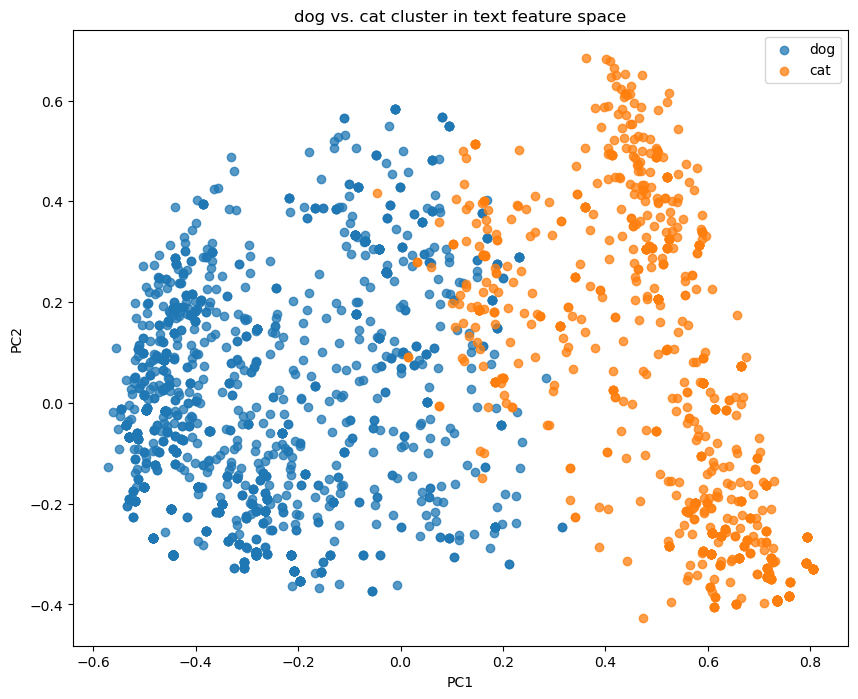

In [21]:
X = annotations_embeddings[filtered_df.index]
y = filtered_df["animal_label"]
pca2 = PCA(n_components=2)
X_pca = pca2.fit_transform(X)

plt.figure(figsize=(10, 8))
for label in ["dog", "cat"]:
    idx = y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.75)
plt.legend()
plt.title("dog vs. cat cluster in text feature space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In the text feature space, the dog cluster is quite compact, while the cat cluster is more dispersed. Importantly, the two clusters are still clearly separable, indicating that the text embeddings effectively distinguish between dog- and cat-related descriptions. <br>
It is very similar in the audio feature space.

#### B2
Copying code from audio_features notebook

Found 9026 .npz files

Loading: 100300.npz

Keys in .npz file:
 - embeddings: shape (221, 768), dtype float32
 - melspectrogram: shape (221, 64), dtype float32
 - mfcc: shape (221, 32), dtype float32
 - mfcc_delta: shape (221, 32), dtype float32
 - mfcc_delta2: shape (221, 32), dtype float32
 - flatness: shape (221, 1), dtype float32
 - centroid: shape (221, 1), dtype float64
 - flux: shape (221, 1), dtype float32
 - energy: shape (221, 1), dtype float32
 - power: shape (221, 1), dtype float32
 - bandwidth: shape (221, 1), dtype float64
 - contrast: shape (221, 7), dtype float64
 - zerocrossingrate: shape (221, 1), dtype float64

Embedding shape: (221, 768)


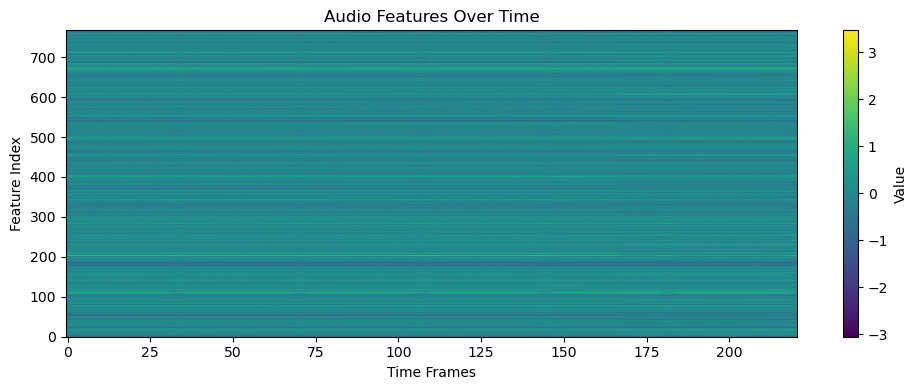

PCA explained variance (first 10 components): [0.6   0.206 0.093 0.038 0.018 0.01  0.005 0.004 0.003 0.003]


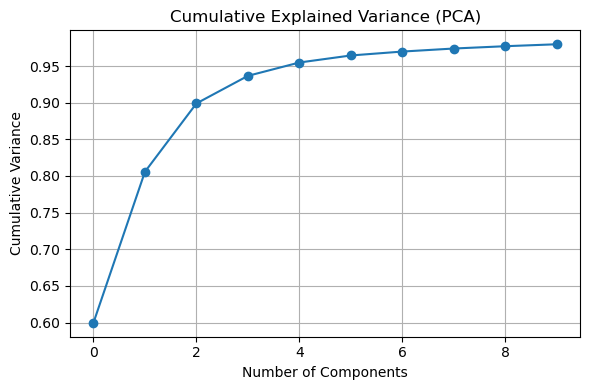

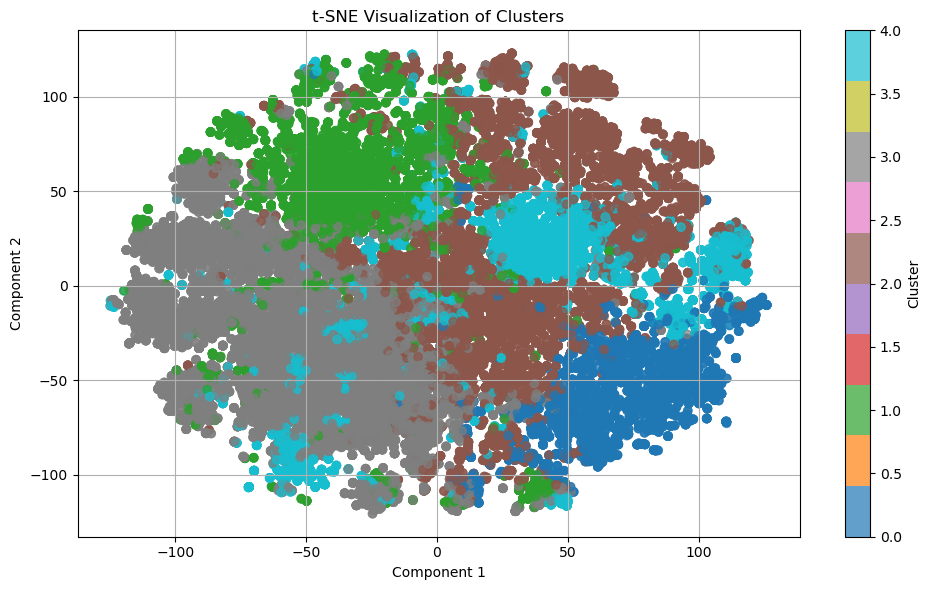


Cluster distribution for silent regions:
 - Cluster 0: 1486 silent vectors
 - Cluster 3: 3982 silent vectors
 - Cluster 1: 1283 silent vectors
 - Cluster 2: 3540 silent vectors
 - Cluster 4: 986 silent vectors

Cluster distribution for annotated regions:
 - Cluster 0: 3331 annotated vectors
 - Cluster 3: 9929 annotated vectors
 - Cluster 1: 5274 annotated vectors
 - Cluster 2: 8679 annotated vectors
 - Cluster 4: 4214 annotated vectors


In [6]:
from sklearn.decomposition import PCA

feature_path = "MLPC2025_dataset/audio_features"

npz_files = [f for f in os.listdir(feature_path) if f.endswith('.npz')]
print(f"Found {len(npz_files)} .npz files")

sample_file = npz_files[0]
print(f"\nLoading: {sample_file}")

data = np.load(os.path.join(feature_path, sample_file))

print("\nKeys in .npz file:")
for key in data.files:
    print(f" - {key}: shape {data[key].shape}, dtype {data[key].dtype}")

if 'embeddings' in data:
    embeddings = data['embeddings']
else:
    for k in data.files:
        if data[k].ndim == 2:
            embeddings = data[k]
            print(f"Using fallback key: {k}")
            break
    else:
        raise ValueError("No suitable 2D feature array found.")

print(f"\nEmbedding shape: {embeddings.shape}")
plt.figure(figsize=(10, 4))
plt.imshow(embeddings.T, aspect='auto', origin='lower', cmap='viridis')
plt.title("Audio Features Over Time")
plt.xlabel("Time Frames")
plt.ylabel("Feature Index")
plt.colorbar(label="Value")
plt.tight_layout()
plt.show()

#pca
pca = PCA(n_components=10)
reduced = pca.fit_transform(embeddings)
explained = pca.explained_variance_ratio_

print(f"PCA explained variance (first 10 components): {np.round(explained, 3)}")
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(explained), marker='o')
plt.title("Cumulative Explained Variance (PCA)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

from itertools import groupby
from operator import itemgetter

annotations_path = "MLPC2025_dataset/annotations.csv"
features_path = "MLPC2025_dataset/audio_features"

annotations = pd.read_csv(annotations_path)
annotated_vectors = []
annotated_texts = [] # NEW
silent_vectors = []

frame_duration = 0.96  # seconds per frame
grouped = annotations.groupby("filename")

for filename, group in grouped:
    file_id = os.path.splitext(filename)[0]
    npz_path = os.path.join(features_path, f"{file_id}.npz")
    
    if not os.path.exists(npz_path):
        continue

    try:
        data = np.load(npz_path)

        if "embeddings" in data:
            embeddings = data["embeddings"]
        else:
            emb_keys = [k for k in data.files if data[k].ndim == 2]
            if not emb_keys:
                continue
            embeddings = data[emb_keys[0]]

        num_frames = embeddings.shape[0]
        used_frames = np.zeros(num_frames, dtype=bool)

        for _, row in group.iterrows():
            onset = row["onset"]
            offset = row["offset"]
            text = row["text"]  # get the text for labeling later
            start_idx = int(onset / frame_duration)
            end_idx = int(offset / frame_duration)
            start_idx = max(start_idx, 0)
            end_idx = min(end_idx, num_frames)

            if start_idx >= end_idx:
                continue

            segment = embeddings[start_idx:end_idx]
            mean_vector = segment.mean(axis=0)
            annotated_vectors.append(mean_vector)
            annotated_texts.append(text)  # collect text here ✅

            used_frames[start_idx:end_idx] = True

        # silent frame handling stays the same
        silent_indices = np.where(~used_frames)[0]
        for k, g in groupby(enumerate(silent_indices), lambda ix: ix[0] - ix[1]):
            group_indices = list(map(itemgetter(1), g))
            if len(group_indices) >= 2:
                silent_segment = embeddings[group_indices]
                mean_vector = silent_segment.mean(axis=0)
                silent_vectors.append(mean_vector)

    except Exception as e:
        print(f"Error processing {filename}: {e}")

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from collections import Counter

# comb vectors
all_vectors = np.vstack([annotated_vectors, silent_vectors])
labels_true = (
    [1] * len(annotated_vectors) + 
    [0] * len(silent_vectors)
)  # 1 = annotated, 0 = silent

#kmeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(all_vectors)

#tnse
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
tsne_coords = tsne.fit_transform(all_vectors)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], 
            c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

silent_cluster_counts = Counter(np.array(cluster_labels)[np.array(labels_true) == 0])
annotated_cluster_counts = Counter(np.array(cluster_labels)[np.array(labels_true) == 1])

print("\nCluster distribution for silent regions:")
for k, v in silent_cluster_counts.items():
    print(f" - Cluster {k}: {v} silent vectors")

print("\nCluster distribution for annotated regions:")
for k, v in annotated_cluster_counts.items():
    print(f" - Cluster {k}: {v} annotated vectors")


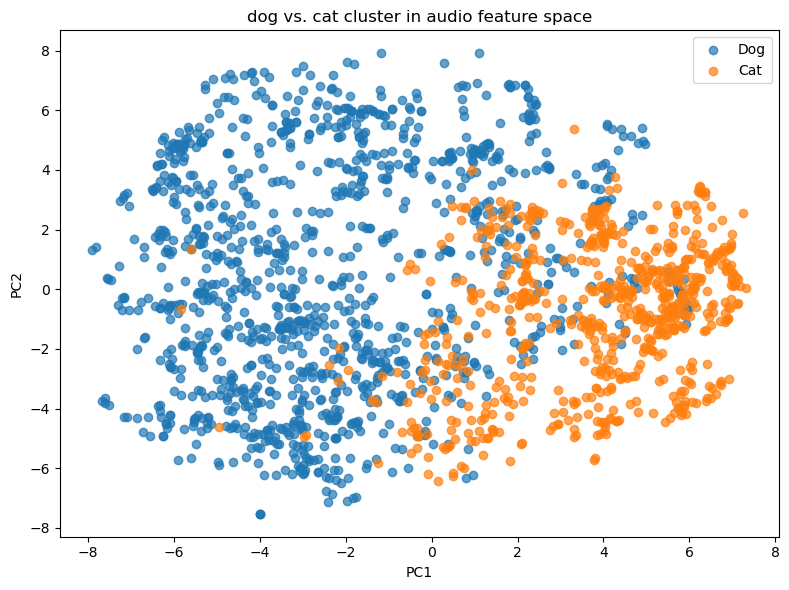

In [23]:
dog_vectors = [vec for vec, txt in zip(annotated_vectors, annotated_texts) if label_dog(txt)]
cat_vectors = [vec for vec, txt in zip(annotated_vectors, annotated_texts) if label_cat(txt)]

all_vectors = np.array(dog_vectors + cat_vectors)
labels = (
    ["Dog"] * len(dog_vectors) +
    ["Cat"] * len(cat_vectors)
)

pca = PCA(n_components=2)
coords = pca.fit_transform(all_vectors)

plt.figure(figsize=(8, 6))
for label in ["Dog", "Cat"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(coords[idx, 0], coords[idx, 1], label=label, alpha=0.7)

plt.title("dog vs. cat cluster in audio feature space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


The plot in the audio feature space shows a similar pattern to the one in the text feature space. However, the cat cluster appears slightly more compact than the dog cluster. Also, the two clusters are less clearly separable in the audio feature space.

### C
How well do the audio feature clusters align with text clusters?

In theory, the audio and text feature clusters should look similar, since they both aim to encode the same concepts. In practice, the visualizations show some alignment, such as distinct clusters for dogs and birds. But there are also noticeable differences, such as some clusters being tighter in the text feature space than in the audio space. <br> 
So while there are some similarities, each space also captures different aspects depending on the modality.